**BIG MODEL**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ------------------------------
# U-Net Model for Retina Segmentation
# ------------------------------
class RetinaSegmentationUNet:
    def __init__(self, input_size=(512, 512, 3)):
        self.input_size = input_size
        self.model = None

    def conv_block(self, inputs, filters, dropout_rate=0.2):
        conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Dropout(dropout_rate)(conv)
        conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
        conv = layers.BatchNormalization()(conv)
        return conv

    def encoder_block(self, inputs, filters, dropout_rate=0.2):
        conv = self.conv_block(inputs, filters, dropout_rate)
        pool = layers.MaxPooling2D((2, 2))(conv)
        return conv, pool

    def decoder_block(self, inputs, skip_features, filters, dropout_rate=0.2):
        upsample = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
        concat = layers.Concatenate()([upsample, skip_features])
        conv = self.conv_block(concat, filters, dropout_rate)
        return conv

    def build_unet(self):
        inputs = layers.Input(shape=self.input_size)
        s1, p1 = self.encoder_block(inputs, 64)
        s2, p2 = self.encoder_block(p1, 128)
        s3, p3 = self.encoder_block(p2, 256)
        s4, p4 = self.encoder_block(p3, 512)
        bottleneck = self.conv_block(p4, 1024, dropout_rate=0.3)
        d1 = self.decoder_block(bottleneck, s4, 512)
        d2 = self.decoder_block(d1, s3, 256)
        d3 = self.decoder_block(d2, s2, 128)
        d4 = self.decoder_block(d3, s1, 64)
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(d4)
        self.model = Model(inputs, outputs, name="U-Net")
        return self.model

    def weighted_binary_crossentropy(self, pos_weight=2.0):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            loss_pos = -pos_weight * y_true * K.log(y_pred)
            loss_neg = -(1 - y_true) * K.log(1 - y_pred)
            return K.mean(loss_pos + loss_neg)
        return loss

    def dice_coefficient(self, y_true, y_pred, smooth=1e-6):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def compile_model(self, learning_rate=1e-4, use_weighted_loss=True, pos_weight=2.0):
        if self.model is None:
            self.build_unet()
        optimizer = Adam(learning_rate=learning_rate)
        loss = self.weighted_binary_crossentropy(pos_weight) if use_weighted_loss else 'binary_crossentropy'
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', self.dice_coefficient])
        return self.model

# ------------------------------
# Data Loader
# ------------------------------
class RetinaDataLoader:
    def __init__(self, image_dir, mask_dir, img_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

    def preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        return img.astype(np.float32) / 255.0

    def preprocess_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size)
        return np.expand_dims(mask.astype(np.float32) / 255.0, axis=-1)

    def load_data(self, test_size=0.2):
        image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        images, masks = [], []

        for img_file in image_files:
            img_path = os.path.join(self.image_dir, img_file)
            mask_name = img_file.replace('_retina', '_mask')
            mask_path = os.path.join(self.mask_dir, mask_name)
            if not os.path.exists(mask_path):
                continue
            images.append(self.preprocess_image(img_path))
            masks.append(self.preprocess_mask(mask_path))

        images, masks = np.array(images), np.array(masks)
        return train_test_split(images, masks, test_size=test_size, random_state=42)

# ------------------------------
# Data Augmentation (fixed shapes)
# ------------------------------
def augment_data(images, masks, augmentation_factor=2):
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        # Ensure correct shape for images
        if len(img.shape) == 2:  # Grayscale image
            img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
        elif img.shape[-1] != 3:  # Wrong number of channels
            img = img[:, :, :3]  # Take first 3 channels
        
        # Ensure correct shape for masks
        if len(mask.shape) == 2:  # 2D mask
            mask = np.expand_dims(mask, axis=-1)
        elif mask.shape[-1] > 1:  # Multi-channel mask
            mask = mask[:, :, :1]  # Take first channel only
        
        augmented_images.append(img.astype(np.float32))
        augmented_masks.append(mask.astype(np.float32))

        h, w = img.shape[:2]

        for _ in range(augmentation_factor - 1):
            # Random rotation
            angle = np.random.uniform(-15, 15)
            center = (w // 2, h // 2)
            rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

            img_rot = cv2.warpAffine(img, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
            mask_rot = cv2.warpAffine(mask[:,:,0], rot_matrix, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
            mask_rot = np.expand_dims(mask_rot, axis=-1)

            # Random brightness
            brightness_factor = np.random.uniform(0.8, 1.2)
            img_bright = np.clip(img_rot * brightness_factor, 0, 1)

            # Random horizontal flip
            if np.random.random() > 0.5:
                img_bright = cv2.flip(img_bright, 1)
                mask_rot = cv2.flip(mask_rot, 1)

            # Ensure image has exactly 3 channels
            if img_bright.shape[-1] != 3:
                if len(img_bright.shape) == 2:
                    img_bright = np.repeat(np.expand_dims(img_bright, axis=-1), 3, axis=-1)
                else:
                    img_bright = img_bright[:, :, :3]  # Take first 3 channels
            
            # Ensure mask has exactly 1 channel
            if mask_rot.shape[-1] != 1:
                if len(mask_rot.shape) == 2:
                    mask_rot = np.expand_dims(mask_rot, axis=-1)
                else:
                    mask_rot = mask_rot[:, :, :1]  # Take first channel

            augmented_images.append(img_bright.astype(np.float32))
            augmented_masks.append(mask_rot.astype(np.float32))

    # Convert to numpy arrays with consistent shapes
    augmented_images = np.stack(augmented_images, axis=0)
    augmented_masks = np.stack(augmented_masks, axis=0)
    
    return augmented_images, augmented_masks

# ------------------------------
# Pipeline
# ------------------------------
class RetinaSegmentationPipeline:
    def __init__(self, input_size=(512,512,3)):
        self.unet = RetinaSegmentationUNet(input_size)
        self.model = None

    def train_model(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=4):
        self.model = self.unet.compile_model()
        callbacks = [
            ModelCheckpoint('best_retina_unet.keras', monitor='val_dice_coefficient', mode='max', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_dice_coefficient', mode='max', patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_dice_coefficient', mode='max', factor=0.5, patience=7, min_lr=1e-7, verbose=1)
        ]
        return self.model.fit(X_train, y_train, validation_data=(X_val,y_val),
                              epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

    def load_model(self, model_path='best_retina_unet.keras'):
        self.model = tf.keras.models.load_model(model_path, custom_objects={
            'dice_coefficient': self.unet.dice_coefficient,
            'loss': self.unet.weighted_binary_crossentropy() if hasattr(self.unet, 'weighted_binary_crossentropy') else None
        })
        print(f"Loaded model: {model_path}")

    def predict_mask(self, image):
        if len(image.shape)==3:
            image = np.expand_dims(image,0)
        return self.model.predict(image)[0]

    def extract_retina(self, img, mask_thresh=0.5):
        mask = self.predict_mask(img)
        binary_mask = (mask>mask_thresh).astype(np.float32)
        if binary_mask.shape[-1]==1:
            binary_mask = np.repeat(binary_mask,3,axis=-1)
        retina_img = img*binary_mask
        return retina_img, binary_mask

# ------------------------------
# Example Usage
# ------------------------------
if __name__=="__main__":
    # Paths
    img_dir = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\output\test\retina_images"
    mask_dir = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\output\test\mask_images"

    # Load Data
    loader = RetinaDataLoader(img_dir, mask_dir)
    X_train, X_val, y_train, y_val = loader.load_data()

    # Augment
    X_train_aug, y_train_aug = augment_data(X_train, y_train, augmentation_factor=3)

    # Train
    pipeline = RetinaSegmentationPipeline()
    history = pipeline.train_model(X_train_aug, y_train_aug, X_val, y_val, epochs=20, batch_size=4)

**SMALL MODEL**

Training samples: 296
Validation samples: 74
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
After augmentation - Training samples: 592
Augmented image shape: (256, 256, 3)
Augmented mask shape: (256, 256, 1)
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7663 - dice_coefficient: 0.7525 - loss: 0.5151
Epoch 1: val_dice_coefficient improved from -inf to 0.77059, saving model to best_retina_unet.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7678 - dice_coefficient: 0.7534 - loss: 0.5129 - val_accuracy: 0.8190 - val_dice_coefficient: 0.7706 - val_loss: 0.4977 - learning_rate: 1.0000e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9813 - dice_coefficient: 0.9150 - loss: 0.1514
Epoch 2: val_dice_coefficient improved from 0.77059 to 0.86698, saving model to best_retina_unet.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9813 - dice_coefficient: 0.9151 - loss: 0.1513 - val_accuracy: 0.8190 - val_dice_coefficient: 0.8670 - val_

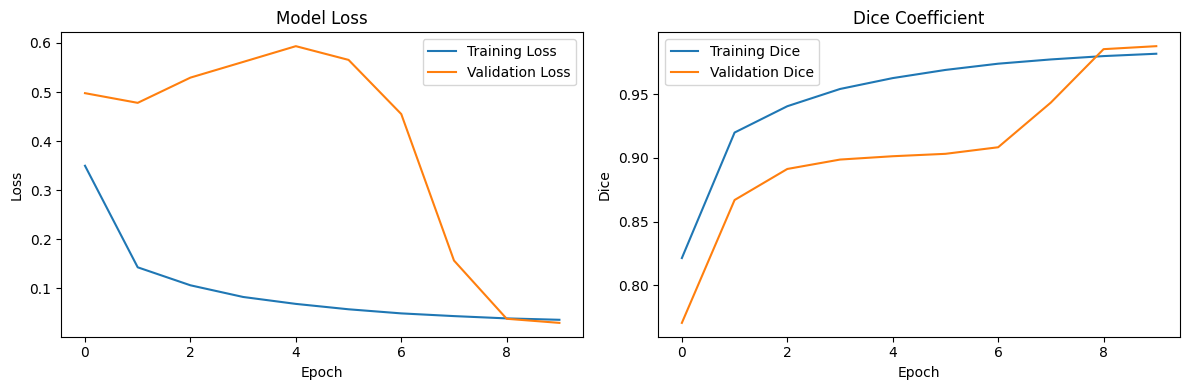

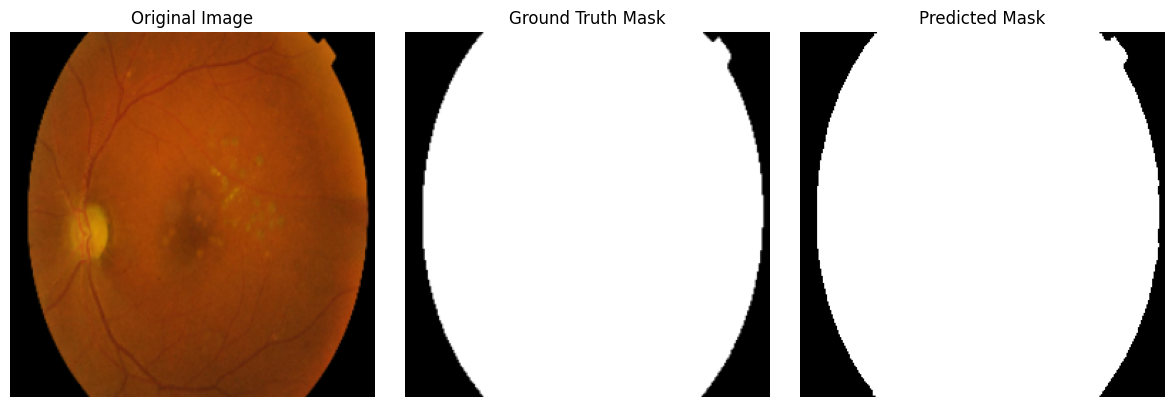

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ------------------------------
# Lightweight U-Net Model for Retina Segmentation
# ------------------------------
class LightweightRetinaUNet:
    def __init__(self, input_size=(256, 256, 3)):
        self.input_size = input_size
        self.model = None

    def conv_block(self, inputs, filters, dropout_rate=0.2):
        conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Dropout(dropout_rate)(conv)
        conv = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
        conv = layers.BatchNormalization()(conv)
        return conv

    def encoder_block(self, inputs, filters, dropout_rate=0.2):
        conv = self.conv_block(inputs, filters, dropout_rate)
        pool = layers.MaxPooling2D((2, 2))(conv)
        return conv, pool

    def decoder_block(self, inputs, skip_features, filters, dropout_rate=0.2):
        upsample = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
        concat = layers.Concatenate()([upsample, skip_features])
        conv = self.conv_block(concat, filters, dropout_rate)
        return conv

    def build_unet(self):
        inputs = layers.Input(shape=self.input_size)
        
        # Encoder (smaller)
        s1, p1 = self.encoder_block(inputs, 32)
        s2, p2 = self.encoder_block(p1, 64)
        s3, p3 = self.encoder_block(p2, 128)
        
        # Bottleneck
        bottleneck = self.conv_block(p3, 256, dropout_rate=0.3)
        
        # Decoder
        d1 = self.decoder_block(bottleneck, s3, 128)
        d2 = self.decoder_block(d1, s2, 64)
        d3 = self.decoder_block(d2, s1, 32)
        
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(d3)
        self.model = Model(inputs, outputs, name="Lightweight_U-Net")
        return self.model

    def dice_coefficient(self, y_true, y_pred, smooth=1e-6):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def compile_model(self, learning_rate=1e-4):
        if self.model is None:
            self.build_unet()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                          metrics=['accuracy', self.dice_coefficient])
        return self.model

# ------------------------------
# Data Loader (with smaller image size)
# ------------------------------
class RetinaDataLoader:
    def __init__(self, image_dir, mask_dir, img_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

    def preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        return img.astype(np.float32) / 255.0

    def preprocess_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return None
        mask = cv2.resize(mask, self.img_size)
        return np.expand_dims(mask.astype(np.float32) / 255.0, axis=-1)

    def load_data(self, test_size=0.2):
        image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        images, masks = [], []

        for img_file in image_files:
            img_path = os.path.join(self.image_dir, img_file)
            mask_name = img_file.replace('_retina', '_mask')
            mask_path = os.path.join(self.mask_dir, mask_name)
            
            if not os.path.exists(mask_path):
                continue
                
            img = self.preprocess_image(img_path)
            mask = self.preprocess_mask(mask_path)
            
            if img is not None and mask is not None:
                images.append(img)
                masks.append(mask)

        images, masks = np.array(images), np.array(masks)
        return train_test_split(images, masks, test_size=test_size, random_state=42)

# ------------------------------
# Fixed Data Augmentation
# ------------------------------
def simple_augment_data(images, masks, augmentation_factor=2):
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        # Ensure consistent shapes
        if len(img.shape) == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
        elif img.shape[-1] != 3:
            img = img[:, :, :3]
            
        if len(mask.shape) == 2:
            mask = mask[:, :, np.newaxis]
        elif mask.shape[-1] > 1:
            mask = mask[:, :, :1]
        
        augmented_images.append(img)
        augmented_masks.append(mask)

        for _ in range(augmentation_factor - 1):
            # Random horizontal flip
            if np.random.random() > 0.5:
                img_aug = cv2.flip(img, 1)
                mask_aug = cv2.flip(mask, 1)
            else:
                # Random brightness
                brightness_factor = np.random.uniform(0.8, 1.2)
                img_aug = np.clip(img * brightness_factor, 0, 1)
                mask_aug = mask
                
            # Ensure consistent shapes after augmentation
            if len(img_aug.shape) == 2:
                img_aug = np.repeat(img_aug[:, :, np.newaxis], 3, axis=-1)
            elif img_aug.shape[-1] != 3:
                img_aug = img_aug[:, :, :3]
                
            if len(mask_aug.shape) == 2:
                mask_aug = mask_aug[:, :, np.newaxis]
            elif mask_aug.shape[-1] > 1:
                mask_aug = mask_aug[:, :, :1]

            augmented_images.append(img_aug)
            augmented_masks.append(mask_aug)

    # Use stack instead of array to ensure consistent shapes
    return np.stack(augmented_images), np.stack(augmented_masks)

# ------------------------------
# Pipeline
# ------------------------------
class RetinaSegmentationPipeline:
    def __init__(self, input_size=(256, 256, 3)):
        self.unet = LightweightRetinaUNet(input_size)
        self.model = None

    def train_model(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=8):
        self.model = self.unet.compile_model()
        callbacks = [
            ModelCheckpoint('best_retina_unet.keras', monitor='val_dice_coefficient', 
                          mode='max', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_dice_coefficient', mode='max', patience=5, 
                         restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_dice_coefficient', mode='max', factor=0.5, 
                             patience=3, min_lr=1e-7, verbose=1)
        ]
        
        history = self.model.fit(
            X_train, y_train, 
            validation_data=(X_val, y_val),
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=callbacks, 
            verbose=1
        )
        
        return history

    def load_model(self, model_path='best_retina_unet.keras'):
        self.model = tf.keras.models.load_model(
            model_path, 
            custom_objects={'dice_coefficient': self.unet.dice_coefficient}
        )
        print(f"Loaded model: {model_path}")

    def predict_mask(self, image):
        if len(image.shape) == 3:
            image = np.expand_dims(image, 0)
        return self.model.predict(image, verbose=0)[0]

    def extract_retina(self, img, mask_thresh=0.5):
        mask = self.predict_mask(img)
        binary_mask = (mask > mask_thresh).astype(np.float32)
        if binary_mask.shape[-1] == 1:
            binary_mask = np.repeat(binary_mask, 3, axis=-1)
        retina_img = img * binary_mask
        return retina_img, binary_mask

# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Paths
    img_dir = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\output\test\retina_images"
    mask_dir = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\output\test\mask_images"

    # Load Data
    loader = RetinaDataLoader(img_dir, mask_dir, img_size=(256, 256))
    X_train, X_val, y_train, y_val = loader.load_data()
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Image shape: {X_train[0].shape}")
    print(f"Mask shape: {y_train[0].shape}")

    # Simple augmentation
    X_train_aug, y_train_aug = simple_augment_data(X_train, y_train, augmentation_factor=2)
    
    print(f"After augmentation - Training samples: {X_train_aug.shape[0]}")
    print(f"Augmented image shape: {X_train_aug[0].shape}")
    print(f"Augmented mask shape: {y_train_aug[0].shape}")

    # Train
    pipeline = RetinaSegmentationPipeline()
    history = pipeline.train_model(X_train_aug, y_train_aug, X_val, y_val, epochs=10, batch_size=8)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Test prediction on a sample
    if len(X_val) > 0:
        sample_img = X_val[7]
        sample_mask = y_val[7]
        pred_mask = pipeline.predict_mask(sample_img)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(sample_img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask[:, :, 0], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0] > 0.5, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('sample_prediction.png')
        plt.show()